In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# モンテカルロ法
N_monte_list = np.arange(1000, 500000+1, 1000)

sampling_rate_list = []

for N_monte in N_monte_list:
    x = np.random.rand(N_monte)
    y = np.random.rand(N_monte)
    
    sampling_rate = np.sum((x**2+y**2)<1) / N_monte
    sampling_rate_list.append(sampling_rate)

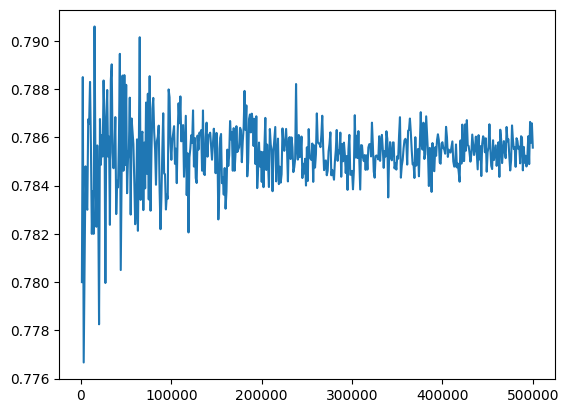

In [3]:
plt.plot(N_monte_list, sampling_rate_list)

In [4]:
# 棄却サンプリング
from scipy.stats import beta, uniform
from scipy import optimize

In [5]:
plt.style.use('ggplot')
np.random.seed(999)

In [6]:
a, b = 1.5, 2

x = np.linspace(beta.ppf(0.001, a, b), beta.ppf(0.999, a, b), 1000)
p = beta(a, b).pdf
res = optimize.fmin(lambda x:-p(x),0.3)
y_max = p(res)  

Optimization terminated successfully.
         Current function value: -1.443376
         Iterations: 10
         Function evaluations: 20


In [7]:
NMSC = 50000
x_mcs = uniform.rvs(size=NMSC)
r = uniform.rvs(size=NMSC)*y_max

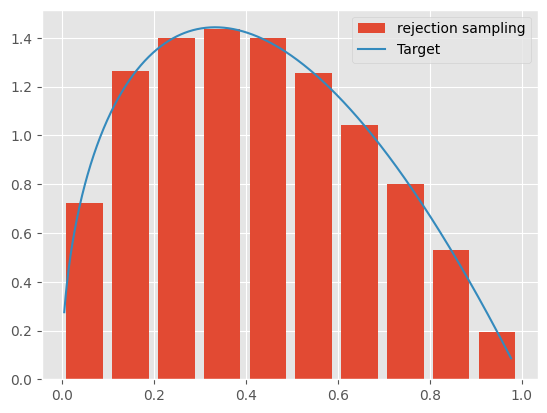

In [8]:
accept = x_mcs[r<=p(x_mcs)]

plt.hist(accept, density=True, rwidth=0.8, label='rejection sampling')
plt.plot(x, beta.pdf(x, a, b), label="Target")
plt.legend()
plt.show()

In [9]:
#遷移核を定義 0:晴れ、1:曇り、2:雨
p_trans=np.zeros([3,3])
p_trans[0,0]=0.6
p_trans[0,1]=0.3
p_trans[0,2]=0.1
p_trans[1,0]=0.5
p_trans[1,1]=0.4
p_trans[1,2]=0.1
p_trans[2,0]=0.4
p_trans[2,1]=0.3
p_trans[2,2]=0.3

#モンテカルロステップ数
NMCS=100

#現在の天気(初期状態では晴れとする)
c_state=0


In [10]:
c_arr = [c_state]

for i in range(NMCS):
    current = np.random.choice(3,1,p=p_trans[c_state,:])
    c_state = current[0]
    c_arr.append(c_state)

print("晴れの確率 : ", c_arr.count(0)/len(c_arr))
print("曇りの確率 : ", c_arr.count(1)/len(c_arr))
print("雨の確率 : ", c_arr.count(2)/len(c_arr))

晴れの確率 :  0.6138613861386139
曇りの確率 :  0.22772277227722773
雨の確率 :  0.15841584158415842


## Pystanを用いたベイズ推定の演習

In [11]:
import pandas as pd
%matplotlib inline
# import seaborn as sns
# sns.set_style('whitegrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [12]:
def generate_sample_data(num, seed=0):
    target_list = []
    feature_list = []

    feature_num = 8
    intercept = 0.2
    weight = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6 ,0.7, 0.8]

    np.random.seed(seed=seed)
    for i in range(num):
        feature_vector = [np.random.rand() for i in range(feature_num)]
        noise = [np.random.normal(0, 0.1) for i in range(feature_num)]
        target = sum([intercept+feature_vector[n]*weight[n]+noise[n] for n in range(feature_num)])

        target_list.append(target)
        feature_list.append(feature_vector)
    
    df = pd.DataFrame(np.c_[target_list, feature_list],
                      columns=['target']+['feature'+str(i) for i in range(feature_num)])
    return df

In [13]:
data = generate_sample_data(num=1000, seed=0)
X = data.drop('target', axis=1)
y = data['target']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [15]:
import pystan
import arviz
import multiprocessing
multiprocessing.set_start_method('fork')

In [16]:
sample_code = """
    data {
    int<lower=0> N;
    int<lower=0> D;
    matrix[N, D] X;
    vector[N] y;
    int<lower=0> N_new;
    matrix[N_new, D] X_new;
    }
    parameters {
        real w0;
        vector[D] w;
        real<lower=0> sigma;
        }
    model {
        for (i in 1:N)
            y[i] ~ normal(w0 + dot_product(X[i], w), sigma);
    }
    generated quantities {
        vector[N_new] y_new;
        for (i in 1:N_new)
            y_new[i] = normal_rng(w0 + dot_product(X_new[i], w), sigma);
    }
"""

In [17]:
sample_data = {
    'N': X_train.shape[0],
    'D': X_train.shape[1],
    'X': X_train,
    'y': y_train,
    'N_new': X_test.shape[0],
    'X_new': X_test
}

In [18]:
sm = pystan.StanModel(model_code=sample_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4ef58d8e8f914ceb6f16d71d1c1ca092 NOW.
In file included from /var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/pystan_s6lw31rj/stanfit4anon_model_4ef58d8e8f914ceb6f16d71d1c1ca092_840062278396594839.cpp:1280:
In file included from /Users/yiadka/.pyenv/versions/3.9.16/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:5:
In file included from /Users/yiadka/.pyenv/versions/3.9.16/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/yiadka/.pyenv/versions/3.9.16/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929:
/Users/yiadka/.pyenv/versions/3.9.16/lib/python3.9/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with " \
 ^
In file included from /var/fold

In [19]:
n_itr = 1000
n_warmup = 500
n_chains = 2

%time fit = sm.sampling(data=sample_data, iter=1000, chains=n_chains, warmup=n_warmup, seed=0, n_jobs=-1, verbose=True, algorithm='NUTS')
print(fit)


Gradient evaluation took 0.000195 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.95 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000203 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.03 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 17)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 900 / 1000 [ 90%]  (Sampling)
Iteration: 900 / 1000 [ 90%]  (Sampling)
Iteration: 1000 / 1000 [100%]  (Sampling)

 Elapsed Time: 1.63689 seconds (Warm-up)
               1.68184 seconds (Sampling)
               3.31873 seconds (Total)

Iteration: 1000 / 1000 [100%]  (Sa

In [20]:
print(fit)

Inference for Stan model: anon_model_4ef58d8e8f914ceb6f16d71d1c1ca092.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
w0            1.6  1.8e-3   0.05   1.51   1.57    1.6   1.64    1.7    703    1.0
w[1]         0.09  1.0e-3   0.03   0.02   0.06   0.09   0.11   0.15   1095    1.0
w[2]         0.25  1.1e-3   0.03   0.18   0.23   0.25   0.27   0.31    924    1.0
w[3]          0.3  9.6e-4   0.03   0.23   0.28    0.3   0.32   0.37   1226    1.0
w[4]         0.39  9.9e-4   0.03   0.32   0.36   0.39   0.41   0.45   1218    1.0
w[5]         0.48  9.5e-4   0.03   0.42   0.46   0.48   0.51   0.55   1199    1.0
w[6]         0.61  1.0e-3   0.03   0.55   0.59   0.61   0.64   0.67   1070    1.0
w[7]         0.67  9.8e-4   0.04   0.61   0.64   0.67   0.69   0.74   1317    1.0
w[8]         0.77  8.9e-4   0.03    0.7   0.75   0.77    0.8   0.84   1506 

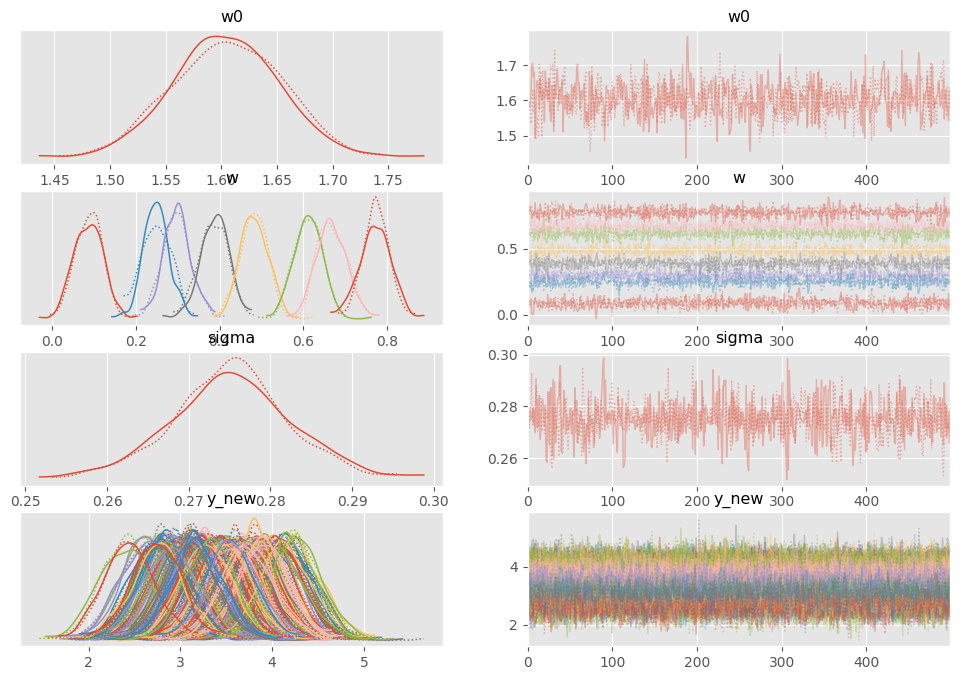

In [21]:
arviz.plot_trace(fit)
plt.show()

In [22]:
y_pred = fit["y_new"].mean(axis=0)
print('MSE(test) = {:.2f}'.format(mean_squared_error(y_test, y_pred)))
print('R^2(test) = {:.2f}'.format(r2_score(y_test, y_pred)))

MSE(test) = 0.07
R^2(test) = 0.73
